In [5]:
import numpy as np
import pandas as pd

### Generate Data

In [6]:
N = 1000000
n = 1

p_treated = 0.5
treatment = np.random.binomial(n, p_treated, size=N)

p_recovery = (0.5 + treatment) / 2. # = 0.25 + 0.5 * treatment
recovery = np.random.binomial(n, p_recovery)

X = pd.DataFrame({'treatment': treatment, 
                  'recovery': recovery})[['treatment', 'recovery']]
X.head()

,treatment,recovery
0,0,1
1,1,1
2,1,0
3,0,0
4,0,0


Treatment causes recovery directly, so the effect of treatment on recovery is just the coefficient, 0.5. That will be the correct ATE. Let's explore with the naive estimator. Treatment is assigned at random, so it should be unbiased for the ATE!

We can estimate $E[Y|D=1]$ and $E[Y|D=0]$ using a quick trick. The groupby operation is handy on discrete data:

In [7]:
X.groupby('treatment').mean()

,recovery
treatment,
0,0.250296
1,0.750623


### Estimate the ATE

#### Since we're using random assignment, we can assume $Y^1$ and $Y^0$ as independent of $D$. Then 
#### $E[\delta] = E[Y^1|D=1] - E[Y^0|D=0] = E[Y|D=1] - E[Y|D=0]$
#### and the naive estimator is unbiased.

#### First, we can estimate the conditionals,

In [8]:
X.groupby(('treatment')).mean()[['recovery']]

,recovery
treatment,
0,0.250296
1,0.750623


#### and then take the difference at each level of the treatment:

In [9]:
X.groupby(('treatment')).mean()[['recovery']].values[1] - X.groupby(('treatment')).mean()[['recovery']].values[0]

array([0.50032682])

#### So we get
#### $E[Y^1|D=1] = 0.75$
#### $E[Y^0|D=0] = 0.25$
#### and the difference is 0.5, the result we can read off from the data generating process!

## Question 4: Estimate the ATE, ATT, ATC when the naive estimator is unbiased.

For this data we've generated, the naive estimator is unbiased. That's because here, $Y^1, Y^0 \perp D$, so 

$$E[Y^1 - Y^0] = E[Y^1] - E[Y^0] = E[Y^1|D=1] - E[Y^0|D=0]$$,

where the last equality comes from this independence assumption, and gives us the naive estimator.

We've already estimated the ATE. How do we get the ATT and ATC?

Since the potential outcomes are independent of $D$, we could condition on any $D$ we like! We could say

$$E[Y^1 - Y^0] = E[Y^1] - E[Y^0] = E[Y^1|D=1] - E[Y^0|D=1]$$

or

$$E[Y^1 - Y^0] = E[Y^1] - E[Y^0] = E[Y^1|D=0] - E[Y^0|D=0]$$.

The first is the ATT, the second is the ATC. They're both equal to the ATE, so ATT = ATC = ATE = 0.5



### How can we break it? That is, how can we make the naive estimator biased for the ATE?

#### First, let's try adding extra noise to the recovery (compare this with the process above):

In [10]:
n = 1

p_contaminated = 0.5
contaminated = np.random.binomial(n, p_contaminated, size=N)

p_treated = 0.5
treatment = np.random.binomial(n, p_treated, size=N)

p_recovery = (0.5 + treatment - 0.5 * contaminated) / 2. # = 0.25 + 0.5 * treatment
recovery = np.random.binomial(n, p_recovery)

X = pd.DataFrame({'treatment': treatment, 
                  'recovery': recovery,
                  'contaminated': contaminated})[['treatment', 'recovery', 'contaminated']]
X.head()

,treatment,recovery,contaminated
0,1,0,1
1,1,0,1
2,1,1,1
3,1,1,0
4,0,0,0


#### Then, the conditionals change!

In [11]:
X.groupby(('treatment')).mean()[['recovery']]

,recovery
treatment,
0,0.125739
1,0.625179


### But the treatment effect stays the same!!!

In [12]:
X.groupby(('treatment')).mean()[['recovery']].values[1] - X.groupby(('treatment')).mean()[['recovery']].values[0]

array([0.49943935])

#### The chances someone in the treatment group is contaminated is the same as for someone in the control group, so, from
#### p_recovery = (0.5 + treatment - 0.5 * contaminated) / 2. # = 0.25 + 0.5 * treatment

#### we can see

#### $E[Y^1|D=1] = E[Y^1|D=0]$
#### and
#### $E[Y^0|D=1] = E[Y^0|D=0]$

#### We need to make treatment and being contaminated associated with each other to create bias! In other words, treatment and outcome have to share a common cause! (what would this causal graph look like?)

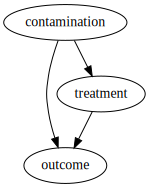

In [13]:
from causalgraphicalmodels import CausalGraphicalModel

G = CausalGraphicalModel(
    nodes=['treatment', 'contamination', 'outcome'],
    edges=[
        ('treatment', 'outcome'),
        ('contamination', 'outcome'),
        ('contamination', 'treatment')
    ]
)

G.draw()

In [24]:
n = 1

p_contaminated = 0.7
contaminated = np.random.binomial(n, p_contaminated, size=N)

p_treated = (0.5 + 0.5 * contaminated) / 2.
treatment = np.random.binomial(n, p_treated)

p_recovery = (0.5 + treatment - 0.5 * contaminated) / 2. # = 0.25 + 0.5 * treatment - 0.25 * contaminated
recovery = np.random.binomial(n, p_recovery)

X = pd.DataFrame({'treatment': treatment, 
                  'recovery': recovery,
                  'contaminated': contaminated})[['treatment', 'recovery', 'contaminated']]
X.head()

,treatment,recovery,contaminated
0,1,0,1
1,1,1,0
2,1,0,1
3,1,1,1
4,0,0,0


#### We can estimate the conditionals again,

In [15]:
X.groupby(('treatment')).mean()[['recovery']]

,recovery
treatment,
0,0.097131
1,0.545076


#### and the naive estimator, which is now biased!

In [16]:
X.groupby(('treatment')).mean()[['recovery']].values[1] - X.groupby(('treatment')).mean()[['recovery']].values[0]

array([0.44794473])

#### We now have a small (roughly 10%) bias for the ATE!

# Question 5

First, let's add the right kind of bias. This will be much easier if we use the potential outcomes style data generating process. First, let's rewrite the data generating process:



In [25]:
n = 1

p_contaminated = 0.7
contaminated = np.random.binomial(n, p_contaminated, size=N)

p_treated = (0.5 + 0.5 * contaminated) / 2.
treatment = np.random.binomial(n, p_treated)

p_recovery = (0.5 - 0.5 * contaminated) / 2. # = 0.25 - 0.25 * contaminated
recovery_0 = np.random.binomial(n, p_recovery)
recovery_1 = np.random.binomial(n, p_recovery + 0.5)
recovery = (treatment == 1) * recovery_1 + (treatment == 0) * recovery_0

X = pd.DataFrame({'treatment': treatment, 
                  'recovery': recovery,
                  'contaminated': contaminated})[['treatment', 'recovery', 'contaminated']]
X.head()

,treatment,recovery,contaminated
0,1,0,1
1,0,0,1
2,0,0,0
3,0,1,0
4,1,1,0


Statistical dependence between the potential outcomes, `recovery_0` and `recovery_1` and `treatment` comes from their common dependence on `contaminated`. As it's written, both potential outcomes will be dependent with `treatment`. If we change it so that only one is statistically dependent with `treatment`, we can make the naive estimator unbiased for the ATC, but not the others. Which one?

Comparing the expressions for the ATT and ATC, we want to know when the naive estimator, $E[Y|D=1] - E[Y|D=0]$ is unbiased for each.

$$ATT = E[Y^1|D=1] - E[Y^0|D=1]$$

and

$$ATC = E[Y^1|D=0] - E[Y^0|D=0]$$.

The ATT's second term is counterfactual, so we need to make assumptions to measure it (we can't just change $Y^0$ to $Y$ like we can with $Y^1$ in the first term). The same is true for the first term in the ATC. We can estimate the ATC if 

$$E[Y^1|D=0] = E[Y^1|D=1] (= E[Y|D=1])$$, 

because then we can use the naive estimator to estimate it. We can do the same for the ATT if 

$$E[Y^0|D=1] = E[Y^0|D=0] (= E[Y|D=0])$$.

To make the naive estimator unbiased for the ATC, we make the first assumption, but not the second. Let's enforce this in our data generating process. We need to make $Y^1$ independent of treatment assignment, but $Y^0$ dependent on treatment assignment. We can do that by removing `contaminated` as a cause of `recovery_1`, but not `recovery_0`. Let's save the potential outcome variables so we can check our answers. I have to reduce the treatment effect so the recovery probability isn't 1. for the treatment group.:

In [30]:
n = 1

p_contaminated = 0.7
contaminated = np.random.binomial(n, p_contaminated, size=N)

p_treated = (0.5 + 0.5 * contaminated) / 2.
treatment = np.random.binomial(n, p_treated)

p_recovery_0 = (0.5 - 0.5 * contaminated) / 2. # = 0.25 - 0.25 * treatment
p_recovery_1 = (0.5) / 2. # = 0.25

recovery_0 = np.random.binomial(n, p_recovery_0)
recovery_1 = np.random.binomial(n, p_recovery_1 + 0.4)
recovery = (treatment == 1) * recovery_1 + (treatment == 0) * recovery_0

X = pd.DataFrame({'treatment': treatment, 
                  'recovery': recovery,
                  'contaminated': contaminated,
                  'recovery_0': recovery_0,
                  'recovery_1': recovery_1})
X.head()

,treatment,recovery,contaminated,recovery_0,recovery_1
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


Let's check the treatment effects now. First, the true ATE:

In [19]:
(X['recovery_1'] - X['recovery_0']).mean()

-0.075183

and the true ATT:

In [20]:
treated = X[X['treatment'] == 1]

(treated['recovery_1'] - treated['recovery_0']).mean()

-0.04422661587307556

and the true ATC:

In [21]:
control = X[X['treatment'] == 0]

(control['recovery_1'] - control['recovery_0']).mean()

-0.09811188068659517

Let's compare these with the naive estimator. We're hoping it'll be equal to the ATC, and not the others.

In [22]:
X[X['treatment'] == 1]['recovery'].mean() - X[X['treatment'] == 0]['recovery'].mean()

-0.09811188068659517

And it worked!